<a href="https://colab.research.google.com/github/thousandoaks/Intro-Causal-Inference/blob/main/code/Copy_of_DoWhy_The_Causal_Story_Behind_Hotel_Booking_Cancellations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install dowhy


     |████████████████████████████████| 123 kB 17.6 MB/s 
  Attempting uninstall: pydot
    Found existing installation: pydot 1.3.0
    Uninstalling pydot-1.3.0:
      Successfully uninstalled pydot-1.3.0


# Ojective of the analysis: Determine what factors cause a hotel booking to be cancelled

We consider what factors cause a hotel booking to be cancelled. This analysis is based on a hotel bookings dataset from Antonio, Almeida and Nunes (2019). On GitHub, the dataset is available at rfordatascience/tidytuesday.


https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-02-11/readme.md


There can be different reasons for why a booking is cancelled. A customer may have requested something that was not available (e.g., car parking), a customer may have found later that the hotel did not meet their requirements, or a customer may have simply cancelled their entire trip. Some of these like car parking are actionable by the hotel whereas others like trip cancellation are outside the hotel’s control. In any case, we would like to better understand which of these factors cause booking cancellations.

The gold standard of finding this out would be to use experiments such as Randomized Controlled Trials wherein each customer is randomly assigned to one of the two categories i.e. each customer is either assigned a car parking or not. However, such an experiment can be too costly and also unethical in some cases (for example, a hotel would start losing its reputation if people learn that its randomly assigning people to different level of service).



## Can we somehow answer our query using only observational data or data that has been collected in the past?

In [2]:
%reload_ext autoreload
%autoreload 2

In [38]:
from scipy import stats

In [3]:
# Config dict to set the logging level
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'INFO',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
# Disabling warnings output
import warnings
from sklearn.exceptions import DataConversionWarning, ConvergenceWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=ConvergenceWarning)
warnings.filterwarnings(action='ignore', category=UserWarning)

#!pip install dowhy
import dowhy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
dataset = pd.read_csv('https://raw.githubusercontent.com/Sid-darthvader/DoWhy-The-Causal-Story-Behind-Hotel-Booking-Cancellations/master/hotel_bookings.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [5]:
dataset.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


## Data Description

For a quick glance of the features and their descriptions the reader is referred here. https://github.com/rfordatascience/tidytuesday/blob/master/data/2020/2020-02-11/readme.md


# Feature Engineering

Lets create some new and meaningful features so as to reduce the dimensionality of the dataset. 

Total Stay = stays_in_weekend_nights + stays_in_week_nights

Guests = adults + children + babies  

Different_room_assigned = 1 if reserved_room_type & assigned_room_type are different, 0 otherwise.

In [6]:
# Total stay in nights
dataset['total_stay'] = dataset['stays_in_week_nights']+dataset['stays_in_weekend_nights']
# Total number of guests
dataset['guests'] = dataset['adults']+dataset['children'] +dataset['babies']
# Creating the different_room_assigned feature
dataset['different_room_assigned']=0
slice_indices =dataset['reserved_room_type']!=dataset['assigned_room_type']
dataset.loc[slice_indices,'different_room_assigned']=1
# Deleting older features
dataset = dataset.drop(['stays_in_week_nights','stays_in_weekend_nights','adults','children','babies'
                        ,'reserved_room_type','assigned_room_type'],axis=1)
dataset.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'meal', 'country', 'market_segment',
       'distribution_channel', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'agent', 'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'total_stay', 'guests',
       'different_room_assigned'],
      dtype='object')

We also remove other columns that either contain NULL values or have too many unique values (e.g., agent ID). We also impute missing values of the country column with the most frequent country. We remove distribution_channel since it has a high overlap with market_segment.

In [7]:
dataset.isnull().sum() # Country,Agent,Company contain 488,16340,112593 missing entries
dataset = dataset.drop(['agent','company'],axis=1)
# Replacing missing countries with most freqently occuring countries
dataset['country']= dataset['country'].fillna(dataset['country'].mode()[0])

In [8]:
dataset = dataset.drop(['reservation_status','reservation_status_date','arrival_date_day_of_month'],axis=1)
dataset = dataset.drop(['arrival_date_year'],axis=1)
dataset = dataset.drop(['distribution_channel'], axis=1)

In [9]:
# Replacing 1 by True and 0 by False for the experiment and outcome variables
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(1,True)
dataset['different_room_assigned']= dataset['different_room_assigned'].replace(0,False)
dataset['is_canceled']= dataset['is_canceled'].replace(1,True)
dataset['is_canceled']= dataset['is_canceled'].replace(0,False)
dataset.dropna(inplace=True)
print(dataset.columns)
dataset.iloc[:, 5:20].head(100)

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_month',
       'arrival_date_week_number', 'meal', 'country', 'market_segment',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'total_stay', 'guests', 'different_room_assigned'],
      dtype='object')


,meal,country,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_stay,guests
0,BB,PRT,Direct,0,0,0,3,No Deposit,0,Transient,0.00,0,0,0,2.0
1,BB,PRT,Direct,0,0,0,4,No Deposit,0,Transient,0.00,0,0,0,2.0
2,BB,GBR,Direct,0,0,0,0,No Deposit,0,Transient,75.00,0,0,1,1.0
3,BB,GBR,Corporate,0,0,0,0,No Deposit,0,Transient,75.00,0,0,1,1.0
4,BB,GBR,Online TA,0,0,0,0,No Deposit,0,Transient,98.00,0,1,2,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,BB,PRT,Online TA,0,0,0,0,No Deposit,0,Transient,73.80,0,1,2,2.0
96,BB,PRT,Online TA,0,0,0,0,No Deposit,0,Transient,117.00,0,1,7,2.0
97,HB,ESP,Offline TA/TO,0,0,0,0,No Deposit,0,Transient,196.54,0,1,7,3.0
98,BB,PRT,Online TA,0,0,0,0,No Deposit,0,Transient,99.30,1,2,7,3.0


In [10]:
dataset = dataset[dataset.deposit_type=="No Deposit"]
dataset.groupby(['deposit_type','is_canceled']).count()

hotel  lead_time  ...  guests  different_room_assigned
deposit_type is_canceled                    ...                                 
No Deposit   False        74947      74947  ...   74947                    74947
             True         29690      29690  ...   29690                    29690

[2 rows x 19 columns]

In [11]:
dataset_copy = dataset.copy(deep=True)

# Relationship betweeen room reassignment and book cancelation

In [12]:
dataset.sample()

,hotel,is_canceled,lead_time,arrival_date_month,arrival_date_week_number,meal,country,market_segment,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,deposit_type,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,total_stay,guests,different_room_assigned
41872,City Hotel,False,0,August,35,BB,PRT,Online TA,0,0,0,0,No Deposit,0,Contract,106.0,0,2,2,2.0,False


In [14]:
dataset[['is_canceled','different_room_assigned']]

,is_canceled,different_room_assigned
0,False,False
1,False,False
2,False,True
3,False,False
4,False,False
...,...,...
119385,False,False
119386,False,False
119387,False,False
119388,False,False


## Does having a room resassigned lead to cancellation ?

In [39]:
stats.pearsonr(dataset['is_canceled'], dataset['different_room_assigned'])

##### We find that assigning rooms decreases cancellations !!!

### There seems to be some correlation between room reasignment and cancellation

But is room reassigment the only confounding variable? 
What if there were some unobserved confounders, would it still influence cancellation ??


# Step-1. Create a Causal Graph

## model Assumptions

1. Market Segment has 2 levels, “TA” refers to the “Travel Agents” and “TO” means “Tour Operators” so it should affect the Lead Time (which is simply the number of days between booking and arrival).

2. Country would also play a role in deciding whether a person books early or not (hence more Lead Time) and what type of Meal a person would prefer.

3. Lead Time would definitely affected the number of Days in Waitlist (There are lesser chances of finding a reservation if you’re booking late). 

4. Additionally, higher Lead Times can also lead to Cancellations.

5. The number of Days in Waitlist, the Total Stay in nights and the number of Guests might affect whether the booking is cancelled or retained.

6. Previous Booking Retentions would affect whether a customer is a Repeated Guest or not. Additionally, both of these variables would affect whether the booking get cancelled or not (Ex- A customer who has retained his past 5 bookings in the past has a higher chance of retaining this one also. Similarly a person who has been cancelling this booking has a higher chance of repeating the same).

7. Booking Changes would affect whether the customer is assigned a different room or not which might also lead to cancellation.

8. Finally, the number of Booking Changes being the only confounder affecting Treatment and Outcome is highly unlikely and its possible that there might be some Unobsevered Confounders, regarding which we have no information being captured in our data.

In [29]:

causal_graph = """digraph {
different_room_assigned[label="Different Room Assigned"];
is_canceled[label="Booking Cancelled"];
booking_changes[label="Booking Changes"];
previous_bookings_not_canceled[label="Previous Booking Retentions"];
days_in_waiting_list[label="Days in Waitlist"];
lead_time[label="Lead Time"];
market_segment[label="Market Segment"];
country[label="Country"];
U[label="Unobserved Confounders"];
is_repeated_guest;
total_stay;
guests;
meal;
hotel;
U->different_room_assigned; U->is_canceled;U->required_car_parking_spaces;
market_segment -> lead_time;
lead_time->is_canceled; country -> lead_time;
different_room_assigned -> is_canceled;
country->meal;
lead_time -> days_in_waiting_list;
days_in_waiting_list ->is_canceled;
previous_bookings_not_canceled -> is_canceled;
previous_bookings_not_canceled -> is_repeated_guest;
is_repeated_guest -> is_canceled;
total_stay -> is_canceled;
guests -> is_canceled;
booking_changes -> different_room_assigned; booking_changes -> is_canceled;
hotel -> is_canceled;
required_car_parking_spaces -> is_canceled;
total_of_special_requests -> is_canceled;
country->{hotel, required_car_parking_spaces,total_of_special_requests,is_canceled};
market_segment->{hotel, required_car_parking_spaces,total_of_special_requests,is_canceled};
}"""

In [32]:
model= dowhy.CausalModel(
        data = dataset,
        graph=causal_graph.replace("\n", " "),
        treatment='different_room_assigned',
        outcome='is_canceled')


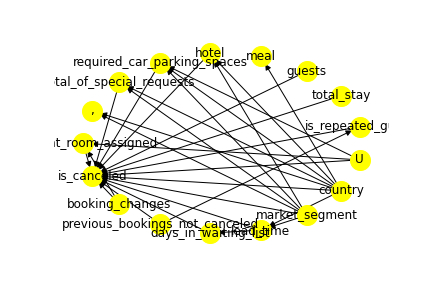

In [33]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

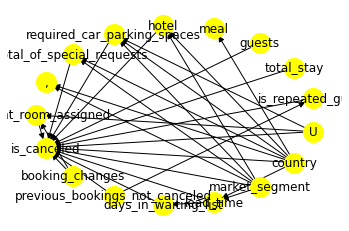

In [34]:
model.view_model()

# Step-2. Identify the Causal Effect

In [35]:
import statsmodels
model= dowhy.CausalModel(
        data = dataset,
        graph=causal_graph.replace("\n", " "),
        treatment="different_room_assigned",
        outcome='is_canceled')
#Identify the causal effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(Expectation(is_canceled|country,previous_bookings_n
d[different_room_assigned]                                                    

                                                                              
ot_canceled,lead_time,hotel,required_car_parking_spaces,booking_changes,is_rep
                                                                              

                                                                              
eated_guest,total_stay,meal,total_of_special_requests,guests,market_segment,da
                                                                              

                    
ys_in_waiting_list))
                    
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→is_canceled then P(is_canceled|different_room_ass

# Step-3. Estimate the identified estimand

In [36]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_stratification",target_units="ate")
# ATE = Average Treatment Effect
# ATT = Average Treatment Effect on Treated (i.e. those who were assigned a different room)
# ATC = Average Treatment Effect on Control (i.e. those who were not assigned a different room)
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                                                 
──────────────────────────(Expectation(is_canceled|country,previous_bookings_n
d[different_room_assigned]                                                    

                                                                              
ot_canceled,lead_time,hotel,required_car_parking_spaces,booking_changes,is_rep
                                                                              

                                                                              
eated_guest,total_stay,meal,total_of_special_requests,guests,market_segment,da
                                                                              

                    
ys_in_waiting_list))
                    
Estimand assumption 1, Unconfoundedness: If U→{different_room_assigned} and U→i

# The result is surprising. It means that having a different room assigned decreases the chances of a cancellation

# It implies that a decision/policy to reduce the number of different_room_assigned at hotels may be counter-productive.

# Step-4. Refute results

In [40]:
refute1_results=model.refute_estimate(identified_estimand, estimate,
        method_name="random_common_cause")
print(refute1_results)

Refute: Add a Random Common Cause
Estimated effect:-0.2507239975864996
New effect:-0.2500216487868105



In [41]:
refute2_results=model.refute_estimate(identified_estimand, estimate,
        method_name="placebo_treatment_refuter")
print(refute2_results)

Refute: Use a Placebo Treatment
Estimated effect:-0.2507239975864996
New effect:8.484475275960156e-05
p value:0.46



In [ ]:
refute3_results=model.refute_estimate(identified_estimand, estimate,
        method_name="data_subset_refuter")
print(refute3_results)

## To do: add code to explain and interpret the model